In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [7]:
path = "/home/intern2/fm2026/fm_flow/code_it/logs"
run_idx = 17
run_ep = 36
log_root = Path(f"/home/intern2/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/test/ep_{run_ep}")
res_files = sorted(log_root.glob("*.mat"))
print(len(res_files))

112


In [8]:
idx = 0
# idx = 100

10
input: (np.float32(-0.8939822), np.float32(5.9220495), np.float32(7.450581e-09), np.float32(0.99999994))
out: (np.float32(-0.910272), np.float32(7.1077085), np.float32(0.0016152859), np.float32(0.95306474))
label: (np.float32(-0.79561996), np.float32(5.4045596), np.float32(2.9802322e-08), np.float32(1.0))


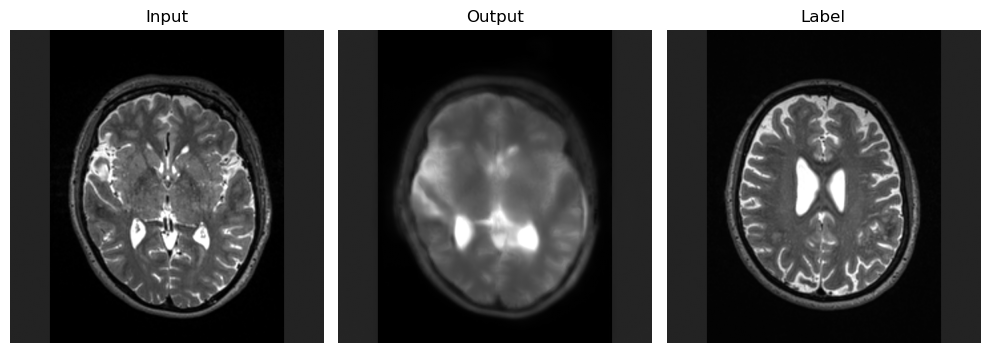

In [19]:
idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input = res_mat["input"].squeeze()
out = res_mat["out"].squeeze()
label = res_mat["label"].squeeze()

x1, x2, y1, y2 = 20, -20, 20, -20


print(f"input: {input.min(), input.max(), input.mean(), input.std()}")
print(f"out: {out.min(), out.max(), out.mean(), out.std()}")
print(f"label: {label.min(), label.max(), label.mean(), label.std()}")

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(out, 0.5)
vmax_out = np.percentile(out, 99.5)


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
print(input.shape)
print(input.min(), input.max())
print(input.mean(), input.std())
print(input)

(512, 512)
-0.9265396 5.36015
2.2351742e-08 1.0
[[-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]
 [-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]
 [-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]
 ...
 [-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]
 [-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]
 [-0.08583792 -0.08583792 -0.08583792 ... -0.08583792 -0.08583792
  -0.08583792]]
